In [1]:
import numpy as np
from pupil_apriltags import Detector
import cv2
from time import sleep, time
from IPython.display import clear_output
from picamera.array import PiYUVArray
from picamera import PiCamera
import matplotlib.pyplot as plt
import signal
%matplotlib inline
stop_process = False

In [2]:
camera_info = {}
#Camera Resolution
camera_info["res"] = (1280, 760)
#Camera Intrinsic Matrix (3x3)
camera_info["K"] = np.array(
    [[631.6058624841243, 0.0, 673.9002987027918], 
     [0.0, 627.4303222760955, 380.85431690312384], 
     [0.0, 0.0, 1.0]])
#The non-default elements of the K array, in the AprilTag specification
camera_info["params"] = [631.605, 627.43, 673.9, 380.85]
#Fisheye Camera Distortion Matrix
camera_info["D"] = np.array(
    [[-0.031080677599846774], 
     [-0.006061559072085696], 
     [-0.0011641369792770276], 
     [0.00028577486827623653]])
#Fisheye flag
camera_info["fisheye"] = True
camera_info["map_1"],camera_info["map_2"] = cv2.fisheye.initUndistortRectifyMap(camera_info["K"],camera_info["D"], 
                                                np.eye(3),camera_info["K"],                                
                                                camera_info["res"],cv2.CV_16SC2)

In [2]:
camera_info = {}
#Camera Resolution
camera_info["res"] = (640, 480)
#Camera Intrinsic Matrix (3x3)
camera_info["K"] = np.array([[313.11130800756115, 0.0, 336.11351317641487], 
                             [0.0, 310.34427179740504, 239.24222723346466], 
                             [0.0, 0.0, 1.0]])
#The non-default elements of the K array, in the AprilTag specification
camera_info["params"] = [313.111, 310.344, 336.114, 239.242]
#Fisheye Camera Distortion Matrix
camera_info["D"] = np.array([[-0.03574382363559852], 
                             [0.0028133336786254765], 
                             [-0.007814648102960479], 
                             [0.003381442340208307]])
#Fisheye flag
camera_info["fisheye"] = True
camera_info["map_1"],camera_info["map_2"]  = cv2.fisheye.initUndistortRectifyMap(camera_info["K"], camera_info["D"], 
                                                                  np.eye(3), camera_info["K"], 
                                                                  camera_info["res"], cv2.CV_16SC2)

In [3]:
families = "tagStandard52h13"
#Size of Tag in Meters
tag_size = .04
tag_size_large=.123
detector = Detector(families=families,nthreads=4,quad_decimate=3.0)


In [4]:
def signal_handler(signal, frame):
        global stop_process
        stop_process = True
signal.signal(signal.SIGINT, signal_handler)

<function _signal.default_int_handler>

In [5]:
class Stream():
    
    def __init__(self,map1,map2):
        self.map1 = map1
        self.map2 = map2
        # Timing arrays
        self.read = []
        self.undist = []
        self.detect = []
        self.end = []
        self.full = []
        self.positions = np.zeros(shape=(3, 1))
        self.raw_frames=[]
        self.frames = []
    def undistort(self, img):
        return cv2.remap(img, self.map1, self.map2, interpolation=cv2.INTER_NEAREST) 
      

    # Called when new image is available
    def write(self, data):
        t1=time()
        # Get the Y component which is the gray image
        I_distorted = np.frombuffer(data, dtype=np.uint8, count=RES[0] * RES[1]).reshape(RES)
        self.read.append(time() - t1)
    
        I = self.undistort(I_distorted)
        self.raw_frames.append(I_distorted)
        self.frames.append(I)
        self.undist.append(time() - t1)
        
        detected_tags = detector.detect(I, estimate_tag_pose=True, camera_params=camera_info["params"],
                                                     tag_size=tag_size)
        self.detect.append(time()-t1)
        
        tmp_poses = [tag.pose_t for tag in detected_tags]
        if tmp_poses:
            avg = np.mean(np.concatenate(tmp_poses, axis=1), axis=1, keepdims=True)
            self.positions = np.hstack((self.positions, avg))

            # If no new tag detections in this frame, assume (naively) that the camera stayed in the same position
            # as the previous frame
        else:
            self.positions = np.hstack((self.positions, self.positions[:, -1:]))
            print("No detections")

        self.end.append(time() - t1)
        self.full.append(time() - t0)

        # Stop if we processed 100 frames
        # Will still record for at most 1 second, check logic below
        if len(self.read) > 100:
            stop_process = True
        
    def print_statistics(self):

        print(f"Time to Read:{np.mean(self.read)}")
        print(f"Time to Undistort:{np.mean(self.undist)-np.mean(self.read)}")
        print(f"Time to Detect:{np.mean(self.detect)-np.mean(self.undist)}")
        print(f"Time to End of Loop:{np.mean(self.end)-np.mean(self.detect)}")
        print(f"Total Time:{np.mean(self.end)}")
        print(f"Estimated FPS:{1/np.mean(self.end)}")
        import pdb;pdb.set_trace()


# Max FPS Stream

In [6]:
MAX_TIME=15
FPS=50
RES=camera_info["res"]
with PiCamera() as camera:
    camera.sensor_mode=7
    camera.resolution = RES
    camera.framerate = FPS
    stream=Stream(camera_info["map_1"], camera_info["map_2"])
    try:
        camera.start_recording(stream, format='yuv')
        t0=time()
        while not stop_process:
            camera.wait_recording(1)
            if (time()-t0)>MAX_TIME:
                camera.stop_recording()
                break
    except Exception as e:
        print(e)
        camera.close()
    stream.print_statistics()
    camera.close()

No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No det

No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No det

BdbQuit: 

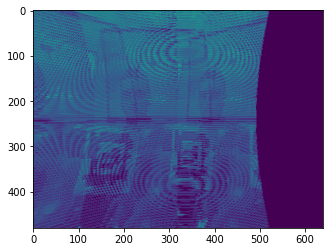

In [9]:
plt.imshow(stream.frames[10])


# Capture Continous

In [13]:
stream.print_statistics()
print(len(stream.read))
print(stream.position[:,:10])

Time to Read:4.437974622661977e-05
Time to Undistort:0.0026345406248523668
Time to Detect:0.011634379921566185
Time to End of Loop:1.8071385706553214e-05
Total Time:0.014331371678351724
Estimated FPS:69.77699151509353
3018


AttributeError: 'Stream' object has no attribute 'position'

In [48]:
RUN_TIMER = 30
positions = np.zeros(shape=(3, 1))
first_frame = True
try:
    rawCapture = PiYUVArray(camera, size=camera_info["res"])
    read=[]
    undist=[]
    detect=[]
    end=[]
    full=[]
    t0 = time()
    for f in camera.capture_continuous(rawCapture, format="yuv", use_video_port=True):
        t1=time()
        if first_frame:
            first_frame = False
            # Reset the buffer for the next image
            rawCapture.truncate(0)
            continue
        # Stop after RUN_TIMER seconds
        if (time() - t0) > RUN_TIMER:
            break
        # Get the intensity component of the image (a trick to get black and white images)
        I_distorted = f.array[:, :, 0]
        rawCapture.truncate(0)
        read.append(time()-t1)
        I= cv2.remap(I_distorted, camera_info["map_1"], camera_info["map_2"], interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT) 
        undist.append(time()-t1)
        detected_tags = detector.detect(I, estimate_tag_pose=True, camera_params=camera_info["params"],
                                                     tag_size=tag_size)
        detect.append(time()-t1)
        tmp_poses = [tag.pose_t for tag in detected_tags]
        if tmp_poses:
            avg=np.mean(np.concatenate(tmp_poses, axis=1), axis=1, keepdims=True)
            positions = np.hstack((positions, avg))
            print(f"Time:{time() - t0:.3f}, X:{avg[0,0]:.3f},Y:{avg[1,0]:.3f},X:{avg[2,0]:.3f}")
        else:
            # If no new tag detections in this frame, assume (naively) that the camera stayed in the same position
            # as the previous frame
            positions = np.hstack((positions, positions[:, -1:]))
            print("No detections")
        end.append(time()-t1)
        full.append(time()-t0)
    print(positions.shape)
    print(f"Time to Read:{np.mean(read)}")
    print(f"Time to Undistort:{np.mean(undist)-np.mean(read)}")
    print(f"Time to Detect:{np.mean(detect)-np.mean(undist)}")
    print(f"Time to End of Loop:{np.mean(end)-np.mean(detect)}")
    print(f"Total Time:{np.mean(end)}")
    print(f"Estimated FPS:{1/np.mean(end)}")
    print(f"Total FPS Processed: {positions.shape[1]/RUN_TIMER}")
    camera.close()
    rawCapture.close()
except Exception as e:
    print(e)
    rawCapture.close()
    camera.close()

No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
No detections
Time:1.021, X:-0.051,Y:-0.020,X:0.338
Time:1.094, X:-0.035,Y:-0.024,X:0.327
Time:1.167, X:-0.026,Y:-0.023,X:0.311
Time:1.262, X:-0.019,Y:-0.019,X:0.305
Time:1.333, X:-0.016,Y:-0.013,X:0.289
Time:1.426, X:-0.014,Y:-0.006,X:0.282
Time:1.499, X:-0.015,Y:0.005,X:0.285
Time:1.575, X:-0.014,Y:0.010,X:0.278
Time:1.674, X:-0.013,Y:0.012,X:0.281
No detections
Time:1.828, X:-0.005,Y:0.019,X:0.288
Time:1.901, X:-0.002,Y:0.019,X:0.287
Time:1.989, X:-0.001,Y:0.016,X:0.287
Time:2.061, X:0.001,Y:0.016,X:0.288
Time:2.144, X:0.002,Y:0.016,X:0.288
Time:2.230, X:0.003,Y:0.016,X:0.292
Time:2.290, X:0.004,Y:0.016,X:0.291
Time:2.367, X:0.004,Y:0.016,X:0.292
Time:2.454, X:0.002,Y:0.011,X:0.285
Time:2.548, X:-0.000,Y:0.005,X:0.280
Time:2.646, X:-0.002,Y:0.003,X:0.273
Time:2.735, X:-0.004,Y:0.002,X:0.271
Time:2.812, X:-0.003,Y:0.003,X:0.271
Time

Time:21.594, X:0.032,Y:0.016,X:0.323
No detections
No detections
No detections
Time:21.866, X:0.032,Y:0.013,X:0.323
Time:21.938, X:0.031,Y:0.012,X:0.324
Time:22.012, X:0.031,Y:0.012,X:0.324
Time:22.078, X:0.031,Y:0.012,X:0.326
Time:22.173, X:0.030,Y:0.012,X:0.324
Time:22.243, X:0.030,Y:0.014,X:0.326
Time:22.324, X:0.029,Y:0.013,X:0.327
Time:22.387, X:0.029,Y:0.013,X:0.329
Time:22.451, X:0.029,Y:0.012,X:0.329
Time:22.518, X:0.029,Y:0.010,X:0.329
Time:22.596, X:0.028,Y:0.010,X:0.328
Time:22.650, X:0.028,Y:0.010,X:0.328
Time:22.717, X:0.028,Y:0.010,X:0.329
Time:22.784, X:0.027,Y:0.010,X:0.329
Time:22.863, X:0.027,Y:0.011,X:0.329
Time:22.950, X:0.027,Y:0.010,X:0.330
Time:23.042, X:0.027,Y:0.010,X:0.329
Time:23.140, X:0.027,Y:0.009,X:0.327
Time:23.210, X:0.026,Y:0.010,X:0.326
Time:23.266, X:0.026,Y:0.010,X:0.325
Time:23.334, X:0.026,Y:0.010,X:0.324
Time:23.412, X:0.026,Y:0.009,X:0.325
Time:23.485, X:0.027,Y:0.008,X:0.325
Time:23.548, X:0.027,Y:0.005,X:0.325
Time:23.615, X:0.027,Y:0.005,X:0.

### To Do Tomorrow

- Figure out why undistort2 doesnt work, see if its faster once working
- Get everything else faster as well

### Timing Dec 16

Get Image from buffer: 0.0010760211944580078 <br>
Undistort: 0.17095403671264647 <br>
Apriltag: 0.02233040809631348 <br>
Other: 0.0008922672271728382 <br>
Total: 0.5627192783355712 <br>


### Notes Dec 17
Switched to 640x480 becuase 10 FPS max with 1280x768
60 FPS with quad-decimate 4, no detections over a meter though
30 FPS with no-quad decimate, better detection distance
20 FPS with more than 2 tags
nthreads=4 adds 1 fps